# Stock market forecasting using Time Series analysis

### Load all the required libraries

In [1]:
import os
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from pmdarima.arima import auto_arima

from pandas_datareader.data import DataReader
import yfinance as yf
from pandas_datareader import data as pdr
yf.pdr_override()

from datetime import datetime

from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

yfinance: pandas_datareader support is deprecated & semi-broken so will be removed in a future verison. Just use yfinance.


In [2]:
stock_data = pdr.get_data_yahoo('GOOG', start='2020-01-01', end=datetime.now())

[*********************100%%**********************]  1 of 1 completed


In [3]:
stock_data

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-01-02,67.077499,68.406998,67.077499,68.368500,68.290787,28132000
2020-01-03,67.392998,68.625000,67.277199,68.032997,67.955666,23728000
2020-01-06,67.500000,69.824997,67.500000,69.710503,69.631264,34646000
2020-01-07,69.897003,70.149498,69.518997,69.667000,69.587814,30054000
2020-01-08,69.603996,70.579002,69.542000,70.216003,70.136192,30560000
...,...,...,...,...,...,...
2024-07-25,174.250000,175.199997,169.050003,169.160004,169.160004,28967900
2024-07-26,168.770004,169.839996,165.865005,168.679993,168.679993,25150100
2024-07-29,170.500000,172.160004,169.720001,171.130005,171.130005,13768900


Visualize the per day closing price of the stock.

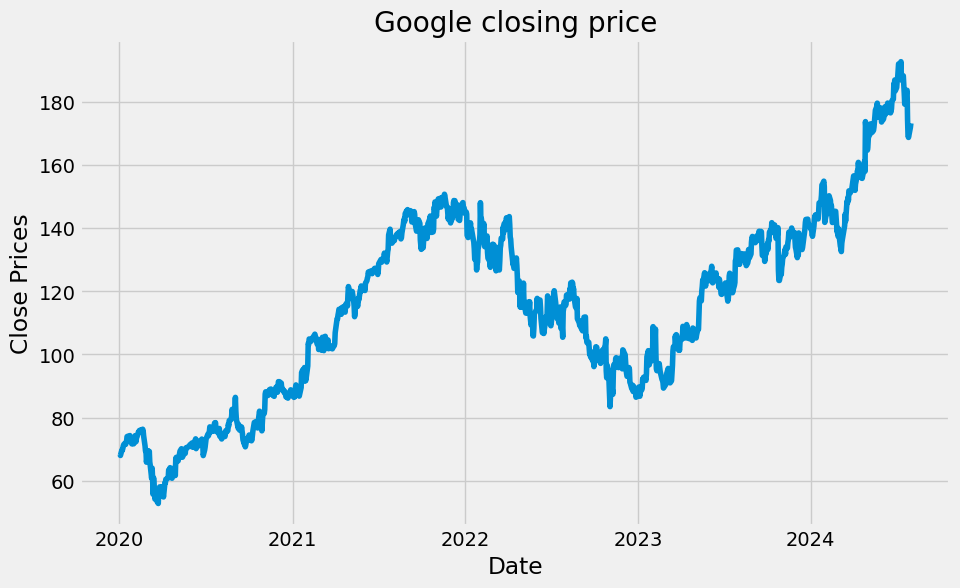

In [4]:
#plot close price
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('Close Prices')
plt.plot(stock_data['Close'])
plt.title('Google closing price')
plt.show()

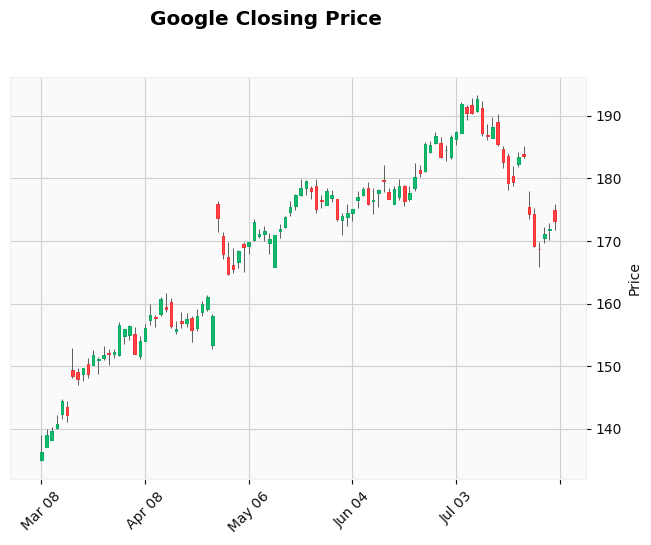

In [5]:
import mplfinance as mpf

mpf.plot(stock_data.tail(100), type='candle', style='yahoo', title='Google Closing Price', ylabel='Price')
plt.show()

### We can also visualize the data in our series through a probability distribution too.

<Axes: ylabel='Density'>

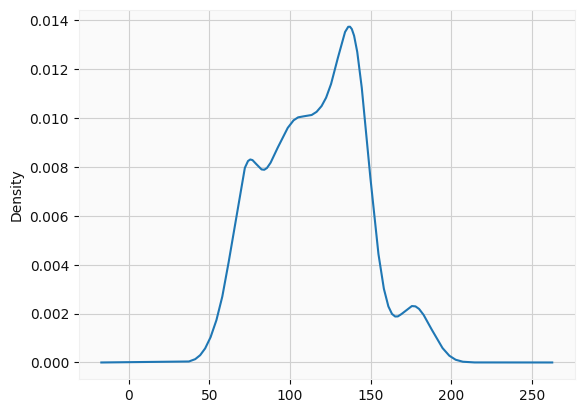

In [6]:
#Distribution of the dataset
df_close = stock_data['Close']
df_close.plot(kind='kde')

Also, a given time series is thought to consist of three systematic components including level, trend, seasonality, and one non-systematic component called noise.

These components are defined as follows:

1. **Level**: The average value in the series.

2. **Trend**: The increasing or decreasing value in the series.

3. **Seasonality**: The repeating short-term cycle in the series.

4. **Noise**: The random variation in the series.

First, we need to check if a series is stationary or not because time series analysis only works with stationary data.


**ADF (Augmented Dickey-Fuller) Test**

The Dickey-Fuller test is one of the most popular statistical tests. It can be used to determine the presence of unit root in the series, and hence help us understand if the series is stationary or not. The null and alternate hypothesis of this test is:


**Null Hypothesis**: The series has a unit root (value of a =1)


**Alternate Hypothesis**: The series has no unit root.


If we fail to reject the null hypothesis, we can say that the series is non-stationary. This means that the series can be linear or difference stationary.


If both mean and standard deviation are flat lines(constant mean and constant variance), the series becomes stationary.


**So let's check for stationarity:

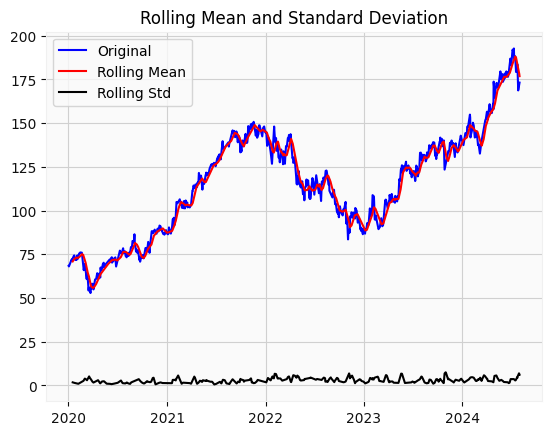

Results of dickey fuller test
Test Statistics                  -0.956652
p-value                           0.768744
No. of lags used                  1.000000
Number of observations used    1150.000000
critical value (1%)              -3.436049
critical value (5%)              -2.864057
critical value (10%)             -2.568110
dtype: float64


In [7]:
#Test for staionarity
def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    #Plot rolling statistics:
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)
    
    print("Results of dickey fuller test")
    adft = adfuller(timeseries,autolag='AIC')
    # output for dft will give us without defining what the values are.
    #hence we manually write what values does it explains using a for loop
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)
    
test_stationarity(df_close)

Through the above graph, we can see the increasing mean and standard deviation and hence our series is not stationary.

We see that the p-value is greater than 0.05 so we cannot reject the Null hypothesis. Also, the test statistics is greater than the critical values. so the data is non-stationary.


In order to perform a time series analysis, we may need to separate seasonality and trend from our series. The resultant series will become stationary through this process.


So let us separate Trend and Seasonality from the time series.

<Figure size 640x480 with 0 Axes>

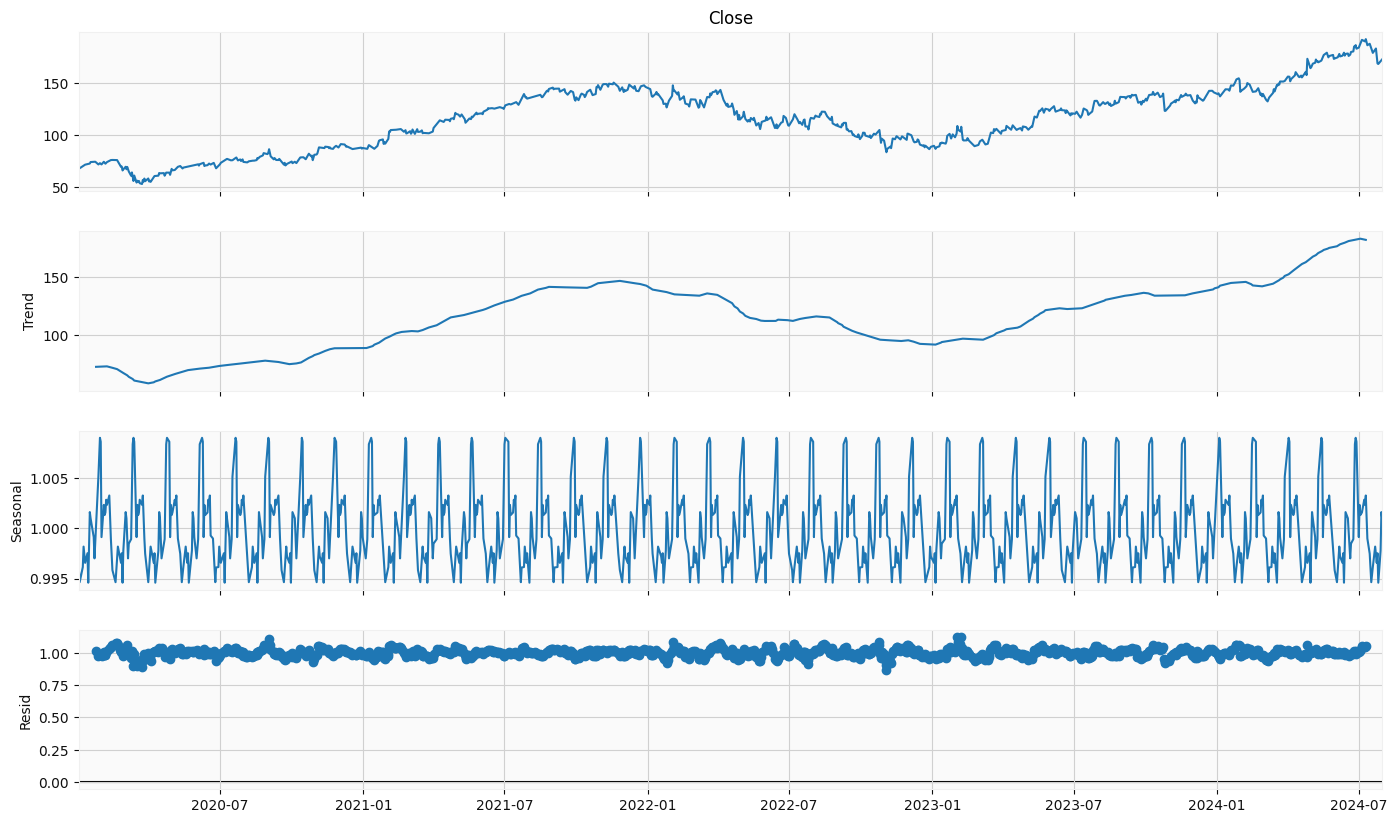

In [8]:
#To separate the trend and the seasonality from a time series, 
# we can decompose the series using the following code.
result = seasonal_decompose(df_close, model='multiplicative', period = 30)
fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(16, 9)

We start by taking a log of the series to reduce the magnitude of the values and reduce the rising trend in the series. Then after getting the log of the series, we find the rolling average of the series. A rolling average is calculated by taking input for the past 12 months and giving a mean consumption value at every point further ahead in series.

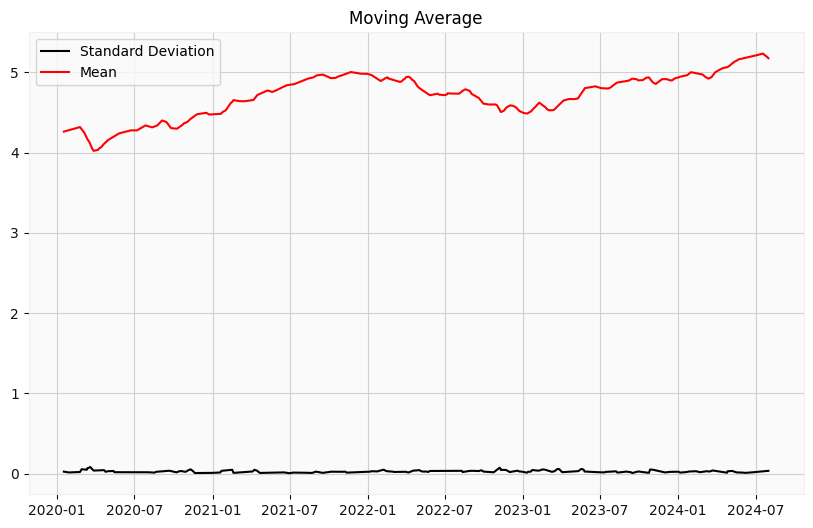

In [9]:
#if not stationary then eliminate trend
#Eliminate trend
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
df_log = np.log(df_close)
moving_avg = df_log.rolling(12).mean()
std_dev = df_log.rolling(12).std()
plt.legend(loc='best')
plt.title('Moving Average')
plt.plot(std_dev, color ="black", label = "Standard Deviation")
plt.plot(moving_avg, color="red", label = "Mean")
plt.legend()
plt.show()

Now we are going to create an ARIMA model and will train it with the closing price of the stock on the train data. So let us split the data into training and test set and visualize it.

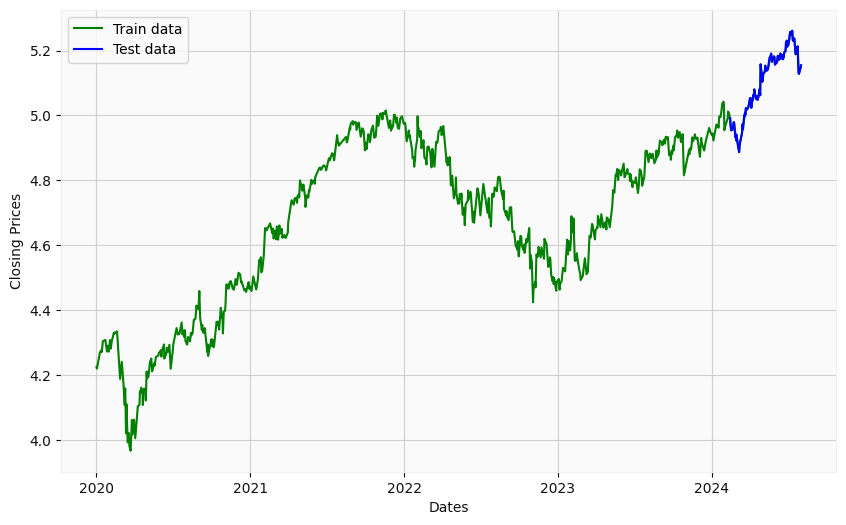

In [10]:

#split data into train and training set
train_data, test_data = df_log[3:int(len(df_log)*0.9)], df_log[int(len(df_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(df_log, 'green', label='Train data')
plt.plot(test_data, 'blue', label='Test data')
plt.legend()


#### Auto ARIMA: Automatically discover the optimal order for an ARIMA model.


The auto_arima function seeks to identify the most optimal parameters for an ARIMA model, and returns a fitted ARIMA model. This function is based on the commonly-used R function, **forecast::auto.arima**.


The **auro_arima** function works by conducting differencing tests (i.e., **Kwiatkowski–Phillips–Schmidt–Shin, Augmented Dickey-Fuller or Phillips–Perron**) to determine the order of differencing, d, and then fitting models within ranges of defined start_p, max_p, start_q, max_q ranges. If the seasonal optional is enabled, auto_arima also seeks to identify the optimal P and Q hyper- parameters after conducting the **Canova-Hansen** to determine the optimal order of seasonal differencing, D.

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-5038.432, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-5046.048, Time=0.12 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-5045.741, Time=0.31 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-5039.225, Time=0.04 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-5044.266, Time=0.53 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-5044.381, Time=0.82 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-5042.229, Time=1.37 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-5046.583, Time=0.05 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-5044.844, Time=0.12 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-5044.963, Time=0.31 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-5046.257, Time=0.19 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-5042.807, Time=0.41 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 4.347 seconds
                               SARIMAX Results                              

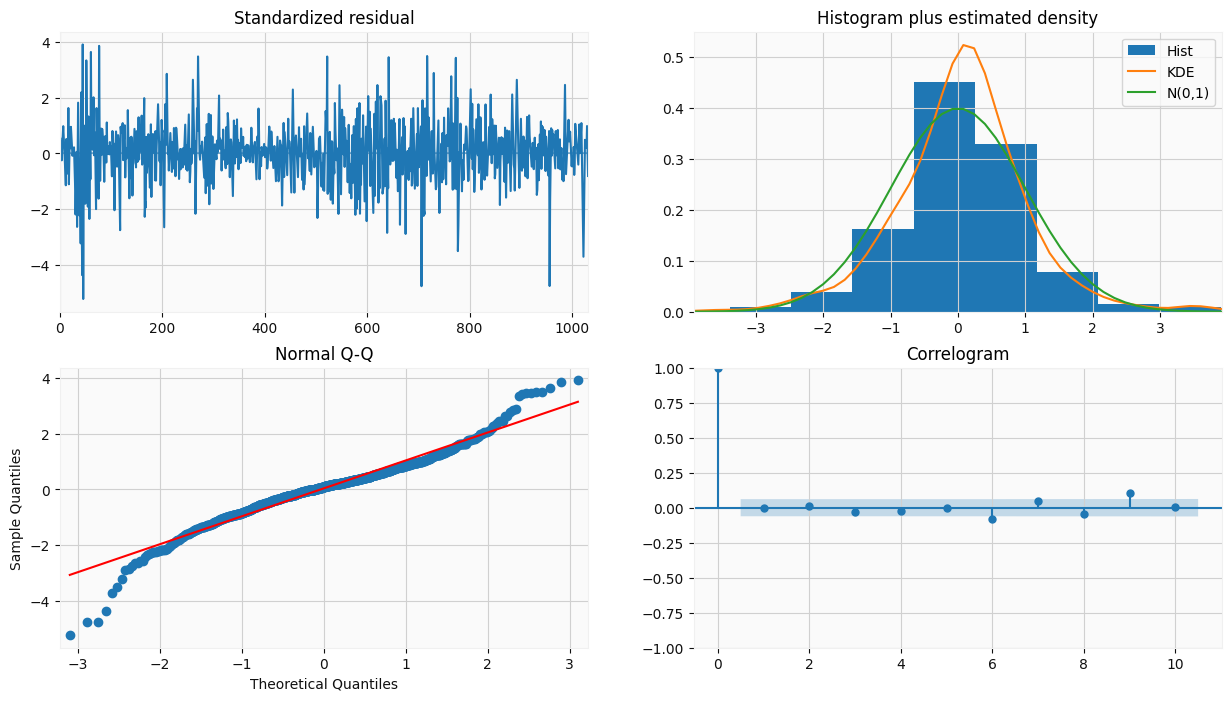

In [11]:
model_autoARIMA = auto_arima(train_data, start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=5, max_q=5, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
print(model_autoARIMA.summary())
model_autoARIMA.plot_diagnostics(figsize=(15,8))
plt.show()

So how to interpret the plot diagnostics?


**Top left**: The residual errors seem to fluctuate around a mean of zero and have a uniform variance.


**Top Right**: The density plot suggest normal distribution with mean zero.


**Bottom left**: All the dots should fall perfectly in line with the red line. Any significant deviations would imply the distribution is skewed.


**Bottom Right**: The Correlogram, aka, ACF plot shows the residual errors are not autocorrelated. Any autocorrelation would imply that there is some pattern in the residual errors which are not explained in the model. So you will need to look for more X’s (predictors) to the model.


Overall, it seems to be a good fit. Let’s start forecasting the stock prices.


Next, create an ARIMA model with provided optimal parameters p, d and q.

In [12]:
#Modeling
# Build Model
model = ARIMA(train_data, order=(0,1,1))  
fitted = model.fit()  
print(fitted.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 1033
Model:                 ARIMA(0, 1, 1)   Log Likelihood                2525.129
Date:                Thu, 01 Aug 2024   AIC                          -5046.257
Time:                        18:06:07   BIC                          -5036.379
Sample:                             0   HQIC                         -5042.509
                               - 1033                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.0936      0.023     -4.064      0.000      -0.139      -0.048
sigma2         0.0004   1.25e-05     35.160      0.000       0.000       0.000
Ljung-Box (L1) (Q):                   0.00   Jarque-

c:\Users\Phyo Pyae Sone\Desktop\FYP-24-S2-39-master\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Phyo Pyae Sone\Desktop\FYP-24-S2-39-master\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Phyo Pyae Sone\Desktop\FYP-24-S2-39-master\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


c:\Users\Phyo Pyae Sone\Desktop\FYP-24-S2-39-master\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\Phyo Pyae Sone\Desktop\FYP-24-S2-39-master\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


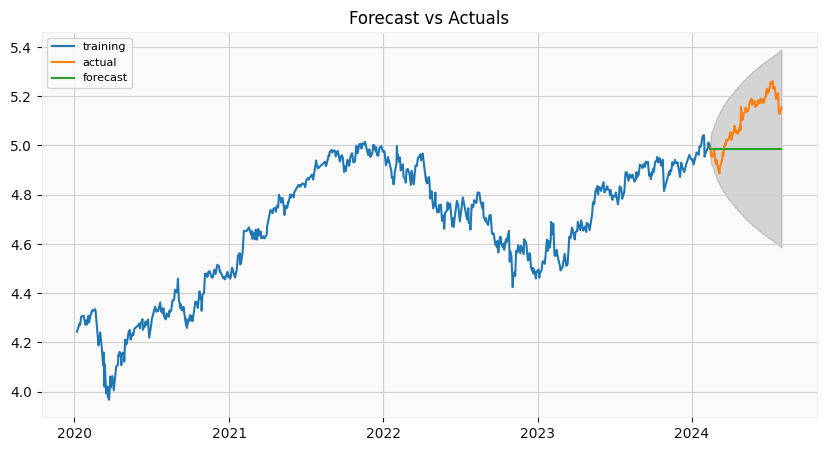

In [13]:
steps = len(test_data) 
fc = fitted.forecast(steps=steps)

# If you need confidence intervals, use `get_forecast` instead
forecast_object = fitted.get_forecast(steps=steps)
se = forecast_object.se_mean
conf = forecast_object.conf_int(alpha=0.05)

fc.index = test_data.index
lower_series = pd.Series(conf.iloc[:, 0].values, index=test_data.index[:len(conf)])
upper_series = pd.Series(conf.iloc[:, 1].values, index=test_data.index[:len(conf)])

# Plotting
plt.figure(figsize=(10, 5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, label='actual')
plt.plot(fc, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()


In [14]:
def plot_seasonal_decomposition(df, model='multiplicative'):
    result = seasonal_decompose(df, model=model, period = 30)
    fig = plt.figure()  
    fig = result.plot()  
    fig.set_size_inches(16, 9)

In [15]:
def get_best_arima_model_params(df, no_stats_log=False):
    trace = not no_stats_log
    model_autoARIMA = auto_arima(df, start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=5, max_q=5, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=trace,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
    if (no_stats_log == False):
        print(model_autoARIMA.summary())
        model_autoARIMA.plot_diagnostics(figsize=(15,8))
        plt.show()
    return model_autoARIMA.order
    

In [22]:
def plot_forecast(fitted_model,train_data, steps):
    fc = fitted_model.forecast(steps=steps)

    # If you need confidence intervals, use `get_forecast` instead
    forecast_object = fitted_model.get_forecast(steps=steps)
    se = forecast_object.se_mean
    conf = forecast_object.conf_int(alpha=0.55)

    fc = np.exp(fc)
    conf = np.exp(conf)
    train_data = np.exp(train_data)
    
    forecast_index = pd.date_range(start=train_data.index[-1] + pd.DateOffset(days=1), periods=steps, freq='D')
    
    fc.index = forecast_index
    lower_series = pd.Series(conf.iloc[:, 0].values, index=forecast_index[:len(conf)])
    upper_series = pd.Series(conf.iloc[:, 1].values, index=forecast_index[:len(conf)])

    # Plotting
    plt.figure(figsize=(10, 5), dpi=100)
    plt.plot(train_data, label='training')
    plt.plot(fc, label='forecast')
    plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.15)
    plt.title('Projection of Stock Prices')
    plt.legend(loc='upper left', fontsize=8)
    plt.show()

In [17]:
def forecast_using_arima(df, days_to_forecast, no_stats_log=False):
    steps = days_to_forecast
    
    df_close = df['Close']
    
    if (no_stats_log == False):
        plot_seasonal_decomposition(df_close)
    
    df_log = np.log(df_close)
    
    p, d, q = get_best_arima_model_params(df_log, no_stats_log)
    model = ARIMA(df_log, order=(p,d,q)) 
    fitted = model.fit() 
    
    if (no_stats_log == False): 
        print(fitted.summary())
    
    plot_forecast(fitted, df_log, steps)

In [18]:
google_stock = pdr.get_data_yahoo('GOOGL', start='2020-01-01', end=datetime.now())

[*********************100%%**********************]  1 of 1 completed


c:\Users\Phyo Pyae Sone\Desktop\FYP-24-S2-39-master\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Phyo Pyae Sone\Desktop\FYP-24-S2-39-master\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Phyo Pyae Sone\Desktop\FYP-24-S2-39-master\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Phyo Pyae Sone\Desktop\FYP-24-S2-39-master\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported 

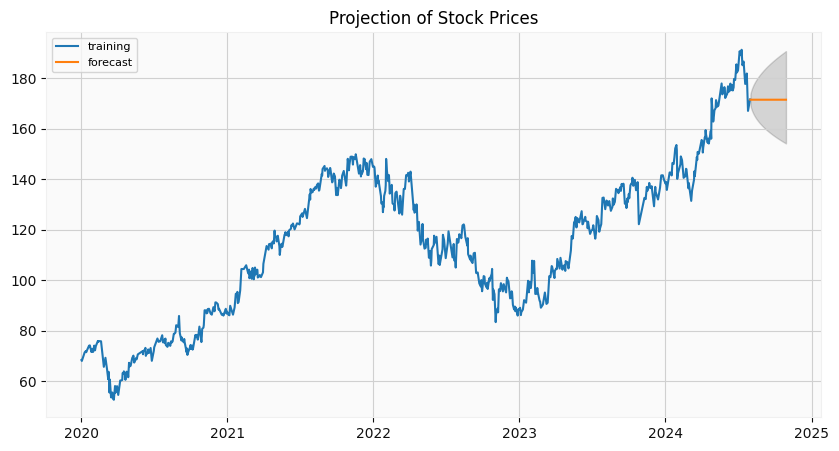

In [23]:
forecast_using_arima(google_stock, 90, no_stats_log=True)